<img src="Credit One Logo.png" />

In [1]:
import pandas as pd
import numpy as np
import scipy
from math import sqrt
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

#estimators
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

#model metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

#cross validation
from sklearn.model_selection import train_test_split

# Importing Data

### Data was preprocessed and explored during C5T2

In [2]:
#data
rawData = pd.read_csv(r'C:\Users\jlegner\Desktop\Data Analytics\Data Analytics Class\Course 5\Task 3\creditselect.csv', header=1)
rawData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,age_bin,limit_bin,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,689,0,0,0,0,"(20.999, 26.0]","(9999.999, 30000.0]",1
1,120000,2,2,2,26,-1,2,0,0,0,...,3261,0,1000,1000,1000,0,2000,"(20.999, 26.0]","(100000.0, 140000.0]",1
2,90000,2,2,2,34,0,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,"(30.0, 34.0]","(70000.0, 100000.0]",0
3,50000,2,2,1,37,0,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,"(34.0, 39.0]","(30000.0, 50000.0]",0
4,50000,1,2,1,57,-1,0,-1,0,0,...,19131,2000,36681,10000,9000,689,679,"(45.0, 79.0]","(30000.0, 50000.0]",0


### Removing BILL_AMT columns due to covariance and low correlation with independent variable.

In [3]:
rawDataNoCov=rawData.drop(['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'], axis=1)
rawDataNoCov.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,age_bin,limit_bin,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,0,689,0,0,0,0,"(20.999, 26.0]","(9999.999, 30000.0]",1
1,120000,2,2,2,26,-1,2,0,0,0,2,0,1000,1000,1000,0,2000,"(20.999, 26.0]","(100000.0, 140000.0]",1
2,90000,2,2,2,34,0,0,0,0,0,0,1518,1500,1000,1000,1000,5000,"(30.0, 34.0]","(70000.0, 100000.0]",0
3,50000,2,2,1,37,0,0,0,0,0,0,2000,2019,1200,1100,1069,1000,"(34.0, 39.0]","(30000.0, 50000.0]",0
4,50000,1,2,1,57,-1,0,-1,0,0,0,2000,36681,10000,9000,689,679,"(45.0, 79.0]","(30000.0, 50000.0]",0


In [4]:
rawDataNoCov.info

<bound method DataFrame.info of        LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0          20000    2          2         1   24      2      2     -1     -1   
1         120000    2          2         2   26     -1      2      0      0   
2          90000    2          2         2   34      0      0      0      0   
3          50000    2          2         1   37      0      0      0      0   
4          50000    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995     220000    1          3         1   39      0      0      0      0   
29996     150000    1          3         2   43     -1     -1     -1     -1   
29997      30000    1          2         2   37      4      3      2     -1   
29998      80000    1          3         1   41      1     -1      0      0   
29999      50000    1          2         1   46      0      0      0      0   

       PAY_5  PAY_6

In [5]:
rawDataNoCov['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [6]:
#Upsample
rawData_majority = rawDataNoCov[rawDataNoCov['default payment next month']==0]
rawData_minority = rawDataNoCov[rawDataNoCov['default payment next month']==1]

rawData_minority_upsampled = resample(rawData_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=23364,    # to match majority class
                                     random_state=123) # reproducible results

rawData_upsampled = pd.concat([rawData_majority, rawData_minority_upsampled])

rawData_upsampled['default payment next month'].value_counts()

1    23364
0    23364
Name: default payment next month, dtype: int64

In [7]:
#Downsample
rawData_majority = rawDataNoCov[rawDataNoCov['default payment next month']==0]
rawData_minority = rawDataNoCov[rawDataNoCov['default payment next month']==1]

rawData_majority_downsampled = resample(rawData_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=6636,    # to match majority class
                                     random_state=123) # reproducible results

rawData_downsampled = pd.concat([rawData_majority_downsampled, rawData_minority])

rawData_downsampled['default payment next month'].value_counts()

1    6636
0    6636
Name: default payment next month, dtype: int64

# Set Dependent/Independent and Train/Test Split

In [8]:
#features
features = rawData_upsampled.drop(['default payment next month'], axis=1)
print('Summary of feature sample')
features.head()

Summary of feature sample


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,age_bin,limit_bin
2,90000,2,2,2,34,0,0,0,0,0,0,1518,1500,1000,1000,1000,5000,"(30.0, 34.0]","(70000.0, 100000.0]"
3,50000,2,2,1,37,0,0,0,0,0,0,2000,2019,1200,1100,1069,1000,"(34.0, 39.0]","(30000.0, 50000.0]"
4,50000,1,2,1,57,-1,0,-1,0,0,0,2000,36681,10000,9000,689,679,"(45.0, 79.0]","(30000.0, 50000.0]"
5,50000,1,1,2,37,0,0,0,0,0,0,2500,1815,657,1000,1000,800,"(34.0, 39.0]","(30000.0, 50000.0]"
6,500000,1,1,2,29,0,0,0,0,0,0,55000,40000,38000,20239,13750,13770,"(26.0, 30.0]","(360000.0, 1000000.0]"


In [9]:
features['SEX'] = pd.Categorical(features.SEX)
features['EDUCATION'] = pd.Categorical(features.EDUCATION)
features['MARRIAGE'] = pd.Categorical(features.MARRIAGE)
features['limit_bin'] = pd.Categorical(features.limit_bin)
features['age_bin'] = pd.Categorical(features.age_bin)
features['PAY_0'] = pd.Categorical(features.PAY_0)
features['PAY_2'] = pd.Categorical(features.PAY_2)
features['PAY_3'] = pd.Categorical(features.PAY_3)
features['PAY_4'] = pd.Categorical(features.PAY_4)
features['PAY_5'] = pd.Categorical(features.PAY_5)
features['PAY_6'] = pd.Categorical(features.PAY_6)
features.dtypes

LIMIT_BAL       int64
SEX          category
EDUCATION    category
MARRIAGE     category
AGE             int64
PAY_0        category
PAY_2        category
PAY_3        category
PAY_4        category
PAY_5        category
PAY_6        category
PAY_AMT1        int64
PAY_AMT2        int64
PAY_AMT3        int64
PAY_AMT4        int64
PAY_AMT5        int64
PAY_AMT6        int64
age_bin      category
limit_bin    category
dtype: object

In [10]:
#dependent variable
depVar = rawData_upsampled['default payment next month']
depVarCat = pd.Categorical(depVar)
print(depVar)
print(depVarCat)

2        0
3        0
4        0
5        0
6        0
        ..
2243     1
27216    1
23617    1
1569     1
5626     1
Name: default payment next month, Length: 46728, dtype: int64
[0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1]
Length: 46728
Categories (2, int64): [0, 1]


# Covariance

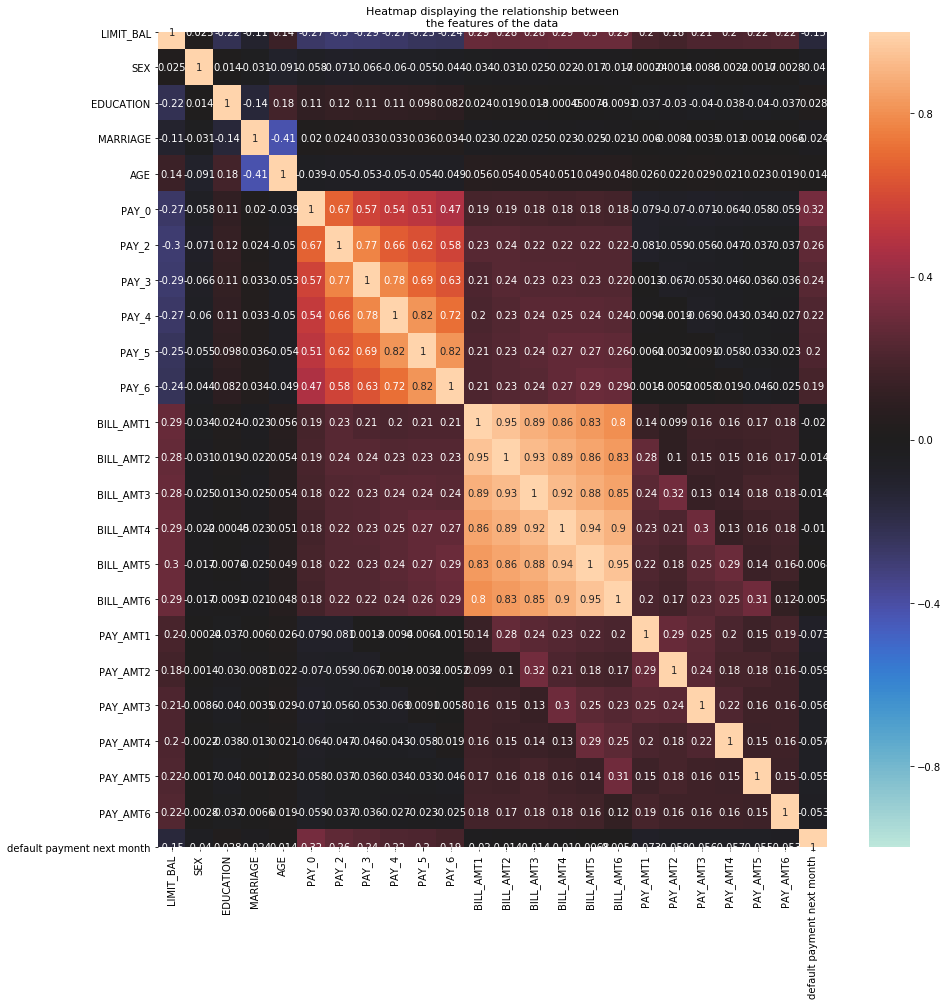

In [11]:
fig, ax = plt.subplots(figsize=(15,15)) 
sn.heatmap(rawData.corr(),annot=True, center=0, vmin=-1, vmax=1, ax=ax)
plt.title('Heatmap displaying the relationship between\nthe features of the data',
         fontsize=11)
plt.show()

### There is high covariance among the bill amount features.  They also provide very little correlation with the independent variable.  Therefore, they will be removed from our selected features (rawDataNoCov - above).

# EDA

C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


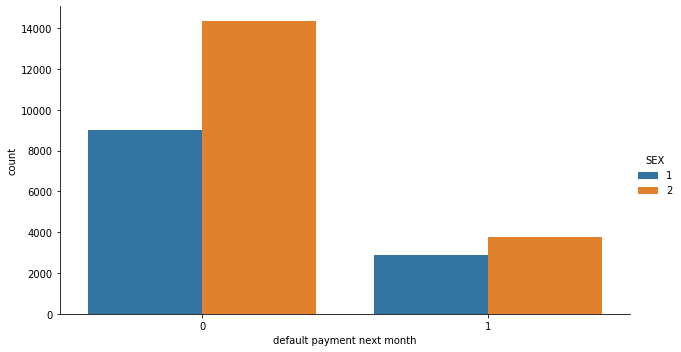

In [12]:
sn.factorplot('default payment next month', data=rawData, hue='SEX', kind='count', aspect=1.75)

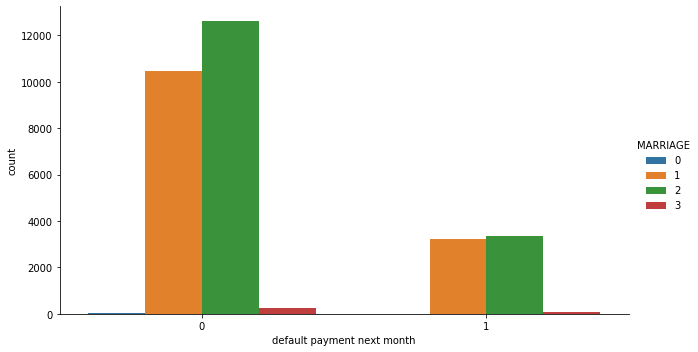

In [13]:
sn.factorplot('default payment next month', data=rawData, hue='MARRIAGE', kind='count', aspect=1.75)

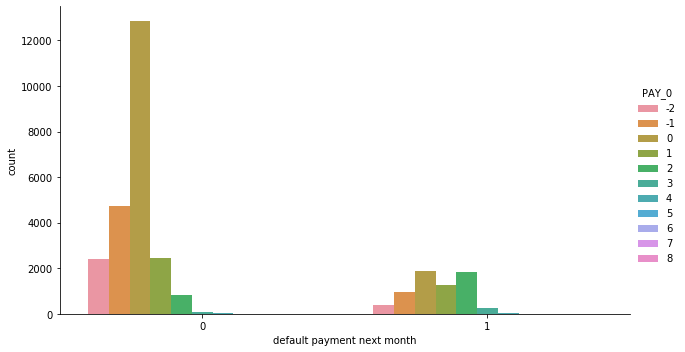

In [14]:
sn.factorplot('default payment next month', data=rawData, hue='PAY_0', kind='count', aspect=1.75)

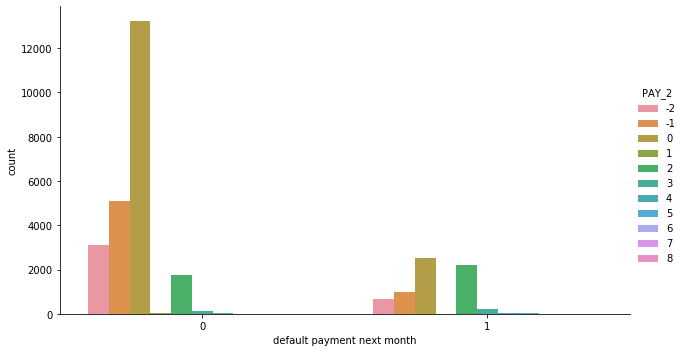

In [15]:
sn.factorplot('default payment next month', data=rawData, hue='PAY_2', kind='count', aspect=1.75)

# Feature Engineering

In [16]:
featuresDummy=pd.get_dummies(features, columns=['age_bin', 'limit_bin'])
featuresClean=featuresDummy.drop(['LIMIT_BAL', 'AGE'], axis=1)
print(featuresClean)

      SEX EDUCATION MARRIAGE PAY_0 PAY_2 PAY_3 PAY_4 PAY_5 PAY_6  PAY_AMT1  \
2       2         2        2     0     0     0     0     0     0      1518   
3       2         2        1     0     0     0     0     0     0      2000   
4       1         2        1    -1     0    -1     0     0     0      2000   
5       1         1        2     0     0     0     0     0     0      2500   
6       1         1        2     0     0     0     0     0     0     55000   
...    ..       ...      ...   ...   ...   ...   ...   ...   ...       ...   
2243    2         3        2     2     0     0     0     2     0      2368   
27216   1         1        2     2     2     2     2     2     2      3000   
23617   2         2        1     0     0     2     2     2     2      3000   
1569    2         2        2    -1     0     0     0     0    -1      3596   
5626    1         2        1     1     3     2     0     0     0         0   

       ...  limit_bin_(100000.0, 140000.0]  limit_bin_(140000.0

In [17]:
X_train, X_test, y_train, y_test = train_test_split(featuresClean, depVar, test_size=.30)
print(X_train.shape, X_test.shape)

(32709, 31) (14019, 31)


In [46]:
pca = PCA(.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_train_pca=y_train
y_test_pca=y_test
print('Explained variance by each component: %s'
      % pca.explained_variance_ratio_)

Explained variance by each component: [0.35294579 0.17633925 0.15313795 0.11279051 0.10740576]


Text(0, 0.5, 'Second Principal Component')

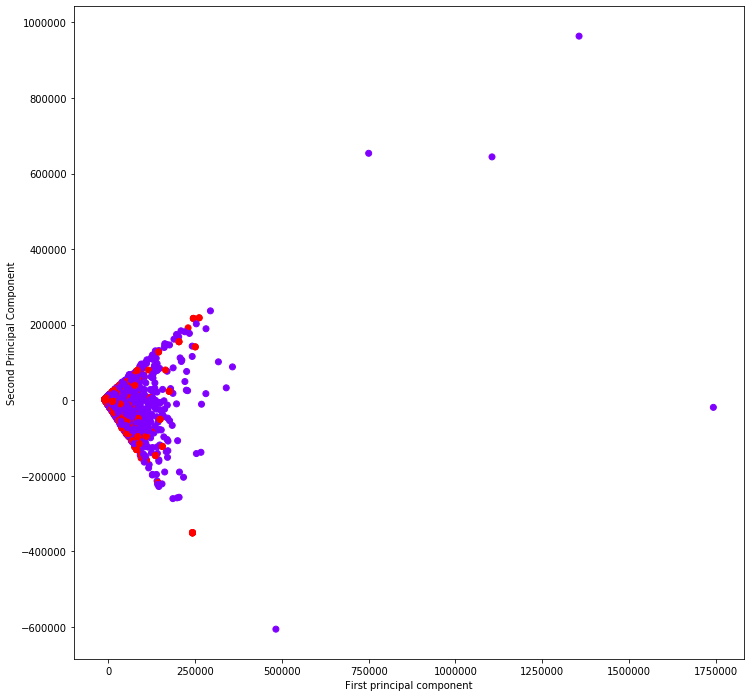

In [36]:
plt.figure(figsize=(12,12))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train, cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

(0, 5)

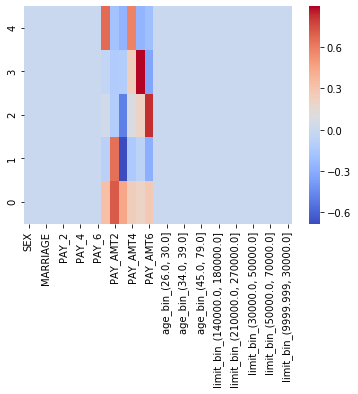

<Figure size 1080x720 with 0 Axes>

In [47]:
map= pd.DataFrame(pca.components_,columns=featuresClean.keys())
ax4= plt.subplot()
plt.figure(figsize=(15,10))
sn.heatmap(map,cmap='coolwarm', ax=ax4)
ax4.set_ylim([0,5])

# Modeling

### We will test three models and choose the best performing.  The three models being tested are KNN, Random Forest, and SVC (an SVM model for classification).

In [22]:
#Models
modelKNN = KNeighborsClassifier(algorithm="auto", n_neighbors=3)
modelRF = RandomForestClassifier(criterion="entropy", class_weight="balanced")
modelSVC = SVC(gamma="auto", C=2)

In [23]:
modelRF.fit(X_train_pca, y_train_pca)
print(cross_val_score(modelRF, X_train_pca, y_train_pca))
modelRF.score(X_train_pca,y_train_pca)
y_pred_RF = modelRF.predict(X_test_pca)

C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.81346295 0.81096946 0.81691433]


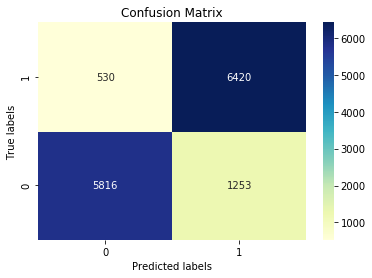

Accuracy 0.8728154647264427
ROC_AUC 0.8732441066527171


In [24]:
cmRF = confusion_matrix(y_test_pca, y_pred_RF)
ax1= plt.subplot()
sn.heatmap(cmRF, annot=True, ax = ax1, fmt="d", cmap="YlGnBu")
ax1.set_ylim([0,2])
ax1.set_xlabel('Predicted labels');
ax1.set_ylabel('True labels'); 
ax1.set_title('Confusion Matrix'); 
plt.show()
print('Accuracy', accuracy_score(y_test_pca, y_pred_RF))
print('ROC_AUC', roc_auc_score(y_test_pca, y_pred_RF))

In [25]:
modelKNN.fit(X_train_pca, y_train_pca)
print(cross_val_score(modelKNN, X_train_pca, y_train_pca))
modelKNN.score(X_train_pca,y_train_pca)
y_pred_KNN = modelKNN.predict(X_test_pca)

C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.69579971 0.69668898 0.6918914 ]


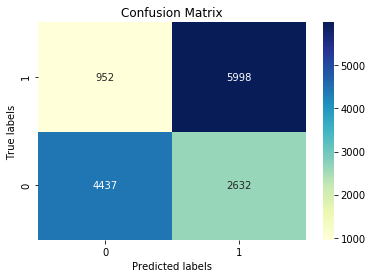

Accuracy 0.7443469577002639
ROC_AUC 0.7453458458300555


In [26]:
cmKNN = confusion_matrix(y_test_pca, y_pred_KNN)
ax2= plt.subplot()
sn.heatmap(cmKNN, annot=True, ax = ax2, fmt="d", cmap="YlGnBu")
ax2.set_ylim([0,2])
ax2.set_xlabel('Predicted labels');
ax2.set_ylabel('True labels'); 
ax2.set_title('Confusion Matrix'); 
plt.show()
print('Accuracy', accuracy_score(y_test_pca, y_pred_KNN))
print('ROC_AUC', roc_auc_score(y_test_pca, y_pred_KNN))

In [27]:
modelSVC.fit(X_train_pca, y_train_pca)
print(cross_val_score(modelSVC, X_train_pca, y_train_pca))
modelSVC.score(X_train_pca,y_train_pca)
y_pred_SVC = modelSVC.predict(X_test_pca)

C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.88875642 0.88471063 0.88873601]


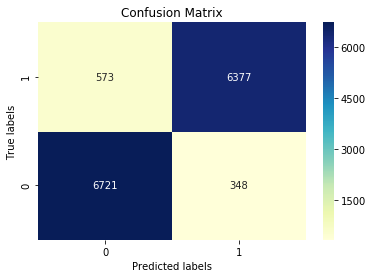

Accuracy 0.9343034453242028
ROC_AUC 0.9341624643417251


In [28]:
cmSVC = confusion_matrix(y_test_pca, y_pred_SVC)
ax3= plt.subplot()
sn.heatmap(cmSVC, annot=True, ax = ax3, fmt="d", cmap="YlGnBu")
ax3.set_ylim([0,2])
ax3.set_xlabel('Predicted labels');
ax3.set_ylabel('True labels'); 
ax3.set_title('Confusion Matrix'); 
plt.show()
print('Accuracy', accuracy_score(y_test_pca, y_pred_SVC))
print('ROC_AUC', roc_auc_score(y_test_pca, y_pred_SVC))

### The best performing model was the SVC, which provided a 89% accuracy on the Training set and 93% accuracy on the Test set.  You can see form the confusion matrix above that this model is able to accurately distinguish between customers likely to default or not.